In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
# we import the modules we need
# you do not have to change anything here
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# Introduction

Objenious by Bouygues Telecom provides Internet of Things services with a LoRa WAN network. Objenious offers various tools, from sensors and smart metering to advanced data analytics.

Objenious provided us with a big dataset (4To+) that contains identified anomalies. The dataset contains metadata (data about the LoRa network). Analyzing such a dataset requires a combination of two competences: knowledge of LoRa and literacy in machine learning.

This TP will help you practice both on a real event: Objenious detected a network degradation on the 29th of January 2019. Due to a high number of requests on the network server on that day, some application servers did not receive their data as usual.

You will have to analyze the data, understand it, and validate your insights.

In practice, such work requires a lot of time. In order to learn as much as possible during this week, we will work on a simplified environment.

For the record, the LoRa technology has three components :
* LoRA: the radio protocol used for communication (868 to 868,6 MHz in Europe);
* LoRa PHY: the LoRa physical layer protocol, which is proprietary and belongs to Semtech;
* LoRa WAN: the network layer protocol that manages the communications. It is maintained by the LoRa Alliance. Objenious is a founding member of the LoRa Alliance. What you will work on, are LoRa WAN logs.


### LoRa WAN

![LoRAWAN](./images/LoraWAN.png)

(source: https://lora-alliance.org/sites/default/files/2018-04/what-is-lorawan.pdf)

A Lora WAN network relies on four key components:

* end-node devices: they are objects with captors that send information (eg. a water meter, etc.). This information consists in an encrypted payload. You will not have to analyze it;

* gateways: they are routers spread out over a territory. They forward the data packets to the network server. Data transmitted by an end-node device can be received by multiple gateways;

* the network server: the centralized server filters duplicate packets, performs security checks, and manages the network (source: https://en.wikipedia.org/wiki/LoRa#cite_note-16). This is what our analysis will focus on;

* application servers: once centralized by the network server, the data is sent to application servers owned by the client. They are used to build dashboards etc. to perform business intelligence.


### Focus: Joins and DDoS

The literature has already identified a potential weakness of Lora WAN: the `join` procedure. For the record,

* the first thing an end-node device must do everytime it has been disconnected from the network (eg. because it has been powered down, has lost it connection, etc.) in order to reconnect is to make a new `join` request. If the network server does not confirm the join, the device will retry until it has successfully connected;

* every communication (joins included) represent a load for the network. 

Researchers concluded that rogue devices or client could perform a Denial-of-service attack (DDos) attack by making an unreasoneable amount of joins. A DDos attack is an attack in which the perpetrator seeks to make a machine or network resource unavailable to its intended users by temporarily or indefinitely disrupting services (https://en.wikipedia.org/wiki/Denial-of-service_attack).

This is exactly what Objenious identified on January 29. For information, network providers are well aware of this type of attacks. The terms and conditions of Objenious are the following:
* Join: 120 Joins/day ( 5 joins / hour)
* DL: 120 messages DL/day ( aprox. 5DL/hour) - a DL (Downlink) is a message going from the device to the server;
* UL: 4800 messages UL/day - an UL (Uplink) is a message going from the server to the device.

### Note about the dataset

The dataset has been reduced for the purpose of the TP. Some data has been changed (eg: the client are mentioned by names instead of ids, timestamps have been replaced by date). Many rows have been removed: the log you will be working on only contain join requests. The columns present in the dataset are the ones required to solve the problem. This choice has been made to learn as much as possible in one week, to focus on the core information of an IOT network and to allow for quick computations.

We can now start analysing the logs.


### Spark (Apache)

The main tool we will use to analyse the logs is Apache Spark. Apache Spark™ is a unified analytics engine for large-scale data processing [https://spark.apache.org/]. Spark has many API: Spark SQL for running SQL queries on structured dataframes, Spark Streaming for streaming data, Spark ML for machine learning, etc.

We will only use Spark SQL to explore the Objenious data.

You can find a pyspark cheatset here: https://s3.amazonaws.com/assets.datacamp.com/blog_assets/PySpark_SQL_Cheat_Sheet_Python.pdf and the documentation here: https://spark.apache.org/docs/latest/api/python/.

In [2]:
# you do not need to change the content of this cell
# we load our session
spark = SparkSession.builder\
                    .master('local')\
                    .appName('DDos')\
                    .getOrCreate()

We now load our first dataframe, which contains the whole dataset. Later on, we will create other dataframes: we will group the data by client, by device, etc. We will also create a clean dataframe once we have identified the anomalies in the main dataframe.

In [3]:
# you do not need to change the content of this cell
# we load the data
df = spark.read.format('json').load('./data/attack.json')

Let us start the data exploration by listing how many entries there are in the dataset. To do this, call the method "count" of your dataframe.

In [6]:
# you do not need to change the content of this cell
df.count()

53168

Let us look at how the entries are structured. We can do this by calling the method "printSchema" of the dataframe.

In [8]:
# you do not need to change the content of this cell
df.printSchema()

root
 |-- Downlink-CRM-ClientID: string (nullable = true)
 |-- Downlink-CRM-DeviceID: string (nullable = true)
 |-- Downlink-GTW-Timestamp: string (nullable = true)
 |-- Downlink-LORA-MType: string (nullable = true)
 |-- Uplink-LNS-FrameErrorCode: string (nullable = true)



As you can see, we have structured data: the logs are organized by columns (`LNS-DownlinkLog-CRM-ClientID`, `LNS-DownlinkLog-CRM-DeviceID`, etc.) and values.

The method `printSchema` only shows the name of the columns of the logs. For the moment, we do not know anything about the values these columns contain. Checking these values will be our first task.

In [9]:
# you do not need to change the content of this cell
df.show()

+---------------------+---------------------+----------------------+-------------------+-------------------------+
|Downlink-CRM-ClientID|Downlink-CRM-DeviceID|Downlink-GTW-Timestamp|Downlink-LORA-MType|Uplink-LNS-FrameErrorCode|
+---------------------+---------------------+----------------------+-------------------+-------------------------+
|                 Zeta| d4a317a2-fe89-478...|   2019-01-27 03:53:27|        JOIN_ACCEPT|                     null|
|                 Evil| f84ebe6f-e12d-47f...|   2019-01-27 03:53:34|        JOIN_ACCEPT|                     null|
|                Gamma| 97e6580d-17bb-4b3...|   2019-01-27 03:53:36|        JOIN_ACCEPT|                     null|
|              Epsilon| ef0a6f26-7257-441...|   2019-01-27 03:53:36|        JOIN_ACCEPT|                     null|
|                 Beta| 625e1400-6857-48a...|   2019-01-27 03:53:41|        JOIN_ACCEPT|                     null|
|                 Beta| 4165597b-252d-4d5...|   2019-01-27 03:53:43|        JOIN

### Exploring the data

The simpliest way to start the analysis of the dataset is to look at each column *individually*. For instance, we can list the unique values each column contains. Once we start having some clues, we will start *combining* the data and make our first assumptions.

We will do this using Spark's dataframe queries.

The first query  we will try is the "select" query. A select query expects the name(s) of the 1+ column(s) we want to query on. Here, for instance, we query on the clients and devices ids: `Downlink-CRM-ClientID`, `Downlink-CRM-DeviceID`.

In [10]:
# you do not need to change the content of this cell
df.select(
        F.col("Downlink-CRM-ClientID"),
        F.col("Downlink-CRM-DeviceID")
    )\
    .show()

+---------------------+---------------------+
|Downlink-CRM-ClientID|Downlink-CRM-DeviceID|
+---------------------+---------------------+
|                 Zeta| d4a317a2-fe89-478...|
|                 Evil| f84ebe6f-e12d-47f...|
|                Gamma| 97e6580d-17bb-4b3...|
|              Epsilon| ef0a6f26-7257-441...|
|                 Beta| 625e1400-6857-48a...|
|                 Beta| 4165597b-252d-4d5...|
|                 Evil| b4069cee-5796-415...|
|                Alpha| 5466d430-594c-4b7...|
|                Alpha| 14b6ef4d-36d4-4d6...|
|                   Nu| 7ab0ce1b-7f86-4f3...|
|                 Evil| b4069cee-5796-415...|
|                Gamma| 98b5f018-d81a-466...|
|                 Evil| 4614371c-2eb6-4e3...|
|                 Evil| f84ebe6f-e12d-47f...|
|                 Evil| f8d07a11-7191-452...|
|                Theta| 81e9ad15-471f-47f...|
|                 Evil| 9ec9344a-a760-460...|
|                Gamma| 30de9ff3-593b-49c...|
|                Theta| efeae1e1-1

This query shows us the name of the devices and the clients they belong to.

Let us count how many entries there are for every client. For this, we will use the `groupBy` query.

In [11]:
# you do not need to change the content of this cell
df.groupBy(
        "Downlink-CRM-ClientID"
    )\
    .count()\
    .show()

+---------------------+-----+
|Downlink-CRM-ClientID|count|
+---------------------+-----+
|                 Evil|35774|
|                Delta| 1396|
|                Theta|  718|
|               Lambda|  621|
|                  Eta|  710|
|                   Nu|  342|
|                 Beta| 4322|
|                   Mu|  298|
|                Kappa|  290|
|                 Iota|  344|
|                Gamma| 6095|
|              Epsilon|  291|
|                 Zeta|  564|
|                Alpha| 1403|
+---------------------+-----+



As you can see, there are 14 clients in the dataset (this is because we removed many entries to allow for fast computations).

You can also "save" you data frame in a python array by using the `.collect()` method.

In [12]:
# you do not need to change the content of this cell
df_array = df.groupBy(
        "Downlink-CRM-ClientID"
    )\
    .count()\
    .collect()

# Here is how the array is structured
print("Length:                                           ", len(df_array))
print("First element:                                    ", df_array[0])
print("Access an element's values by its index:          ", df_array[0][0])
print("Access an element's valyes by its colum's name:   ", df_array[0]["Downlink-CRM-ClientID"])

Length:                                            14
First element:                                     Row(Downlink-CRM-ClientID='Evil', count=35774)
Access an element's values by its index:           Evil
Access an element's valyes by its colum's name:    Evil


This query would be easier to read if sorted. To do this, we will use the `sort` clause.

In [13]:
# you do not need to change the content of this cell
# the F.desc function tells spark to sort the dataframe on the "count" column
# you will have to reuse F function later on when writing your own query
df.groupBy(
        "Downlink-CRM-ClientID"
    ).count(
    ).sort(
        F.desc("count")  # F.asc("count") would have sorted the dataset in an ascending order
    ).show() 

+---------------------+-----+
|Downlink-CRM-ClientID|count|
+---------------------+-----+
|                 Evil|35774|
|                Gamma| 6095|
|                 Beta| 4322|
|                Alpha| 1403|
|                Delta| 1396|
|                Theta|  718|
|                  Eta|  710|
|               Lambda|  621|
|                 Zeta|  564|
|                 Iota|  344|
|                   Nu|  342|
|                   Mu|  298|
|              Epsilon|  291|
|                Kappa|  290|
+---------------------+-----+



This query tells us that Evil made much more requests than other clients. Absolute values are interesting to look at but seldom tell the whole story. For instance, the preceeding query does not answer the following question: is Evil a big client (a very high number of request would then be normal)? Is Evil a small client? How does Evil behave in comparison with other clients?

Since we are working with time series, the next step will be to query the data by day. We will do this using a `where` clause.

In [14]:
# you do not need to change the content of this cell
df.select(
        F.col("Downlink-CRM-ClientID")
    ).where(
        F.dayofmonth("Downlink-GTW-Timestamp").isin([27])  # we query on the day 27
    ).groupBy(
        F.col("Downlink-CRM-ClientID")
    ).count()\
    .sort(
        F.desc("count")
    ).show() 

+---------------------+-----+
|Downlink-CRM-ClientID|count|
+---------------------+-----+
|                 Evil| 3206|
|                 Beta| 1274|
|                Gamma|  779|
|                Alpha|  436|
|                Delta|  407|
|                Theta|  219|
|                  Eta|  214|
|               Lambda|  159|
|                 Zeta|  153|
|                 Iota|  110|
|                   Nu|  104|
|                Kappa|   89|
|              Epsilon|   82|
|                   Mu|   73|
+---------------------+-----+



Repeating the query for every day would be inefficient and error prone (for instance, if we wanted to modify the query we would have to do it for every queried day). It is now time to write our first python function to automate the exploration tasks.

The last query we wrote lists, for the day 27, the unique values that the `LNS-DownlinkLog.CRM-ClientID` column contains and their occurences.

It should be nice to be able to repeat this task just by passing the name of the column and the queried days to a function, instead of having to rewrite the whole query every time.

To do it, just copy the previous query in the following function. Replace the `LNS-DownlinkLog.CRM-ClientID` string by the `column_name` parameter and the `[27]` list by the `days` list.

Once you are done, run the two following cells. The first cell will save your function and the second one will run it. 

In [4]:
# you must change the content of this cell

def get_distinct_values(df, column_name, days):
    """
    This function queries the distinct values we can find in the dataset for the specified column.
    
    Parameters
    ----------
    df : pyspark.sql.dataframe.DataFrame
        A spark dataframe.
    column_name : str
        The name of the column that we are querying.
    days : list of int
        The days of the month for which the data should be selected.
        
    Returns
    -------
    distinct_values : pyspark.sql.dataframe.DataFrame
        A pyspark dataframe containing two columns: the queried column and the # of occurences for each value.
        The dataframe is ordered by the # of occurences.
    """
    # select the distinct values and their count
    distinct_values = df.select(
        F.col(column_name)
    ).where(
        F.dayofmonth("Downlink-GTW-Timestamp").isin(days)  # we query on the day 27
    ).groupBy(
        F.col(column_name)
    ).count()\
    .sort(
        F.desc("count")
    )
    # return
    return distinct_values

In [5]:
# you do not need to change the content of this cell
distinct_values = get_distinct_values(df, column_name="Downlink-CRM-ClientID", days=[26, 27, 28, 29])

In [17]:
# you do not need to change the content of this cell
distinct_values.show()

+---------------------+-----+
|Downlink-CRM-ClientID|count|
+---------------------+-----+
|                 Evil|35774|
|                Gamma| 6095|
|                 Beta| 4322|
|                Alpha| 1403|
|                Delta| 1396|
|                Theta|  718|
|                  Eta|  710|
|               Lambda|  621|
|                 Zeta|  564|
|                 Iota|  344|
|                   Nu|  342|
|                   Mu|  298|
|              Epsilon|  291|
|                Kappa|  290|
+---------------------+-----+



The good news is that the query can now be called programmatically. Here is how to do it with a for loop.

We focus on the columns that are related to the join requests. 

+-------------------+-----+
|Downlink-LORA-MType|count|
+-------------------+-----+
|        JOIN_ACCEPT| 8666|
|               null|  111|
+-------------------+-----+



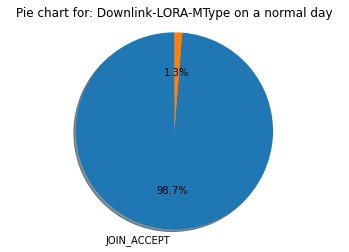

In [25]:
# you do not need to change the content of this cell
distinct_values = get_distinct_values(df, column_name='Downlink-LORA-MType', days=[28])
distinct_values.show()
labels, sizes = [], []
for row in distinct_values.collect():
    labels.append(row['Downlink-LORA-MType'])
    sizes.append(row['count'])
labels = np.where(labels==None, "None", labels)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Pie chart for: {}".format('Downlink-LORA-MType on a normal day'))
plt.show()

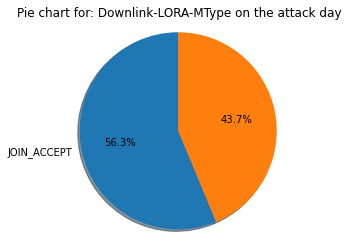

In [19]:
# you do not need to change the content of this cell
distinct_values = get_distinct_values(df, column_name='Downlink-LORA-MType', days=[29])
labels, sizes = [], []
for row in distinct_values.collect():
    labels.append(row['Downlink-LORA-MType'])
    sizes.append(row['count'])
labels = np.where(labels==None, "None", labels)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Pie chart for: {}".format('Downlink-LORA-MType on the attack day'))
plt.show()

In our case, a join either works or returns a failure. This is because we have selected a subset of the dataset - the join queries - for the TP.

It is now time to analyze combinations of data. In the next query, we will check the evolutions of errors by hour.

In [27]:
# you do not need to change the content of this cell
df_errors_by_hour = df.groupBy(
        # these are the columns already present in the dataset
        F.dayofmonth("Downlink-GTW-Timestamp").alias("day"),
        F.hour("Downlink-GTW-Timestamp").alias("hour"),
    ).agg(
        # these are the values to be computed
        F.count(F.lit(1)).alias("nb_records"),  # this lines simply counts the nb. of records
        F.count("Uplink-LNS-FrameErrorCode").alias("nb_errors"),
    ).sort(
        # these are the columns to sort on
        F.asc("day"), 
        F.asc("hour"), 
    )
print(df_errors_by_hour.collect())

[Row(day=27, hour=3, nb_records=42, nb_errors=2), Row(day=27, hour=4, nb_records=350, nb_errors=5), Row(day=27, hour=5, nb_records=353, nb_errors=1), Row(day=27, hour=6, nb_records=341, nb_errors=3), Row(day=27, hour=7, nb_records=360, nb_errors=1), Row(day=27, hour=8, nb_records=360, nb_errors=6), Row(day=27, hour=9, nb_records=369, nb_errors=5), Row(day=27, hour=10, nb_records=389, nb_errors=8), Row(day=27, hour=11, nb_records=360, nb_errors=6), Row(day=27, hour=12, nb_records=354, nb_errors=4), Row(day=27, hour=13, nb_records=376, nb_errors=6), Row(day=27, hour=14, nb_records=369, nb_errors=5), Row(day=27, hour=15, nb_records=358, nb_errors=6), Row(day=27, hour=16, nb_records=372, nb_errors=10), Row(day=27, hour=17, nb_records=352, nb_errors=10), Row(day=27, hour=18, nb_records=348, nb_errors=7), Row(day=27, hour=19, nb_records=341, nb_errors=3), Row(day=27, hour=20, nb_records=370, nb_errors=0), Row(day=27, hour=21, nb_records=376, nb_errors=8), Row(day=27, hour=22, nb_records=361,

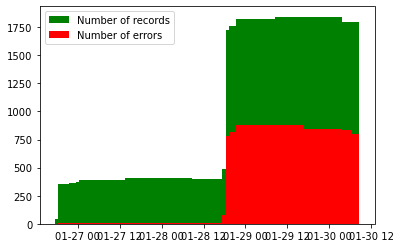

In [28]:
# you do not need to change the content of this cell
def bar_plot_by_hour(df_errors_by_hour):
    """ Requires a df with day, hour, nb_records and nb_errors. """
    import datetime
    times = []
    nb_records = []
    nb_errors = []
    for row in df_errors_by_hour.rdd.collect():
        times.append(datetime.datetime(year=2019, month=1, day=row["day"], hour=row["hour"]))
        nb_records.append(row["nb_records"])
        nb_errors.append(row["nb_errors"])
    plt.bar(times, nb_records, color='g', label='Number of records')
    plt.bar(times, nb_errors, color='r', alpha=1, label='Number of errors')
    plt.legend()
    try:
        # zeppelin
        z.show(plt)
        plt.close()
    except:
        plt.show()
bar_plot_by_hour(df_errors_by_hour)

The DDoS attack of January 29 is clearly visible on that plot.

The next step will be to 
* group the entries by day, by client and by device;
* count the number of records, the number of errors, the error percentage;
* sort the recors by day and records.

This query is for you. It should return the following columns:
* `day`
* `LNS-DownlinkLog.CRM-ClientID`
* `LNS-DownlinkLog.CRM-DeviceID`
* `nb_records`
* `nb_errors`
* `pct_errors`

Have a look at the queries we just wrote and try to adapt them. Do not forget to add aliases in your `groupBy` clause.

In [6]:
# you must change the content of this cell
def get_joins_by_devices(df):
    return df.groupBy(
        # these are the columns already present in the dataset
     F.dayofmonth("Downlink-GTW-Timestamp").alias("day"),
     F.col("Downlink-CRM-ClientID").alias("Downlink-CRM-ClientID"),
     F.col("Downlink-CRM-DeviceID").alias("Downlink-CRM-DeviceID"),
    ).agg(
        # these are the values to be computed
        F.count(F.lit(1)).alias("nb_records"),
        F.count("Uplink-LNS-FrameErrorCode").alias("nb_errors"),
        (F.count("Uplink-LNS-FrameErrorCode") / F.count(F.lit(1)) * 100).alias("pct_errors"),
    ).sort(
        # these are the columns to sort on
        F.asc("day"), 
        F.asc("nb_records"), 
        
    )

In [7]:
# you do not need to change the content of this cell
df_joins_by_devices = get_joins_by_devices(df)
df_joins_by_devices.show()

+---+---------------------+---------------------+----------+---------+-----------------+
|day|Downlink-CRM-ClientID|Downlink-CRM-DeviceID|nb_records|nb_errors|       pct_errors|
+---+---------------------+---------------------+----------+---------+-----------------+
| 27|                 Iota| 346bc7fb-8210-476...|         1|        0|              0.0|
| 27|                Gamma| 0e5d7e0e-e431-48a...|         1|        0|              0.0|
| 27|                Gamma| 3b50cd3e-8718-4e3...|         2|        0|              0.0|
| 27|                Gamma| d02d9c78-2b26-4ad...|         2|        0|              0.0|
| 27|              Epsilon| 2abb5d2a-69eb-45b...|         2|        0|              0.0|
| 27|                Gamma| b12f89fa-ee96-45f...|         2|        0|              0.0|
| 27|                Gamma| 8986c9a0-3c35-4ec...|         2|        0|              0.0|
| 27|                Gamma| 6ba1249e-a82a-4bb...|         2|        0|              0.0|
| 27|                

We can now plot the number of join requests by client by day.

The X axis represents the % of errors. The Y axis the number of request on the given day. The radius of the circles depends on the number of devices the client owns.

In [8]:
# you do not need to change the content of this cell

def _scatter_plot(labels, x_axis, y_axis, points_size=None, x_min=None, x_max=None, y_min=None, y_max=None, title="", color='b', axhline=None):
    fig, ax = plt.subplots()
    if points_size is not None:
        ax.scatter(x_axis, y_axis, color=color, s=points_size * 10)
    else:
        ax.scatter(x_axis, y_axis, color=color)
    for i in range(len(labels)):
        ax.annotate(labels[i], (x_axis[i], y_axis[i]))
    if x_min and x_max:
        plt.xlim((x_min, x_max))
    if y_min and y_max:
        plt.ylim((y_min, y_max))
    if axhline:
        plt.axhline(y=axhline, color='r', linestyle='-')
    plt.title(title)
    try:
        z.show(plt)
        plt.close()
    except:
        plt.show()

def _group_by_client(df):
    df = df.groupBy(
        # these are the columns already present in the dataset
        "day",
        "Downlink-CRM-ClientID",
    ).agg(
        # these are the values to be computed
        F.countDistinct("Downlink-CRM-DeviceID").alias("nb_devices"),
        F.sum("nb_records").alias("nb_records"),
        F.sum("nb_errors").alias("nb_errors"),
        (F.sum("nb_errors") / F.sum("nb_records") * 100).alias("pct_errors"),
    ).sort(
        # these are the columns to sort on
        F.desc("day"),
        F.desc("nb_records"),
    )
    return df

def _array_by_client(df):
    dtype_by_client = [
        ('day', 'int'),
        ('Downlink-CRM-ClientID', '<U10'),
        #('CRM-DeviceID', '<U64'),
        ('nb_devices', 'int'),
        ('nb_records', 'int'),
        ('nb_errors', 'int'),
        ('pct_errors', 'float')
    ]
    array = np.array(df.collect(), dtype=dtype_by_client)
    return array

def _array_by_device(df):
    dtype_by_client = [
        ('day', 'int'),
        ('Downlink-CRM-ClientID', '<U10'),
        ('Downlink-CRM-DeviceID', '<U64'),
        ('nb_records', 'int'),
        ('nb_errors', 'int'),
        ('pct_errors', 'float')
    ]
    array = np.array(df.collect(), dtype=dtype_by_client)
    return array

def _array_by_device_by_hour(df):
    dtype_by_client = [
        ('day', 'int'),
        ('hour', 'int'),
        ('Downlink-CRM-ClientID', '<U10'),
        ('Downlink-CRM-DeviceID', '<U64'),
        ('nb_records', 'int'),
        ('nb_errors', 'int'),
        ('pct_errors', 'float')
    ]
    array = np.array(df.collect(), dtype=dtype_by_client)
    return array

def scatter_plot(df, day=None, by="client", title=None, axhline=None):
    if not title:
        title = "Analysis by {}. ".format(by)
    if by == "client":
        df = _group_by_client(df)
        array = _array_by_client(df)
    else:
        array = _array_by_device(df)
    if day and day != 29:
        title += "Day: {}".format(day)
        array = array[np.where(array['day'] == day)]
        x_min=-0.2
        x_max=5
        y_min=0
        y_max=4000
    else:
        if day == 29:
            array = array[np.where(array['day'] == day)]
            title += "Day: {}".format(day)
        else:
            title = "All days"
        x_min=None
        x_max=None
        y_min=None
        y_max=None
    _scatter_plot(
        labels=array['Downlink-CRM-ClientID'] if by == "client" else [],
        x_axis=array['pct_errors'],
        y_axis=array['nb_records'],
        points_size=array['nb_devices'] if by == "client" else 1,
        x_min=x_min,
        x_max=x_max,
        y_min=y_min,
        y_max=y_max,
        title=title,
        color=["orange" if di == "Evil" else "b" for di in array['Downlink-CRM-ClientID']],
        axhline=axhline,
    )


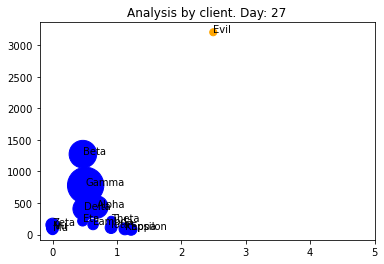

In [54]:
# you do not need to change the content of this cell
scatter_plot(df_joins_by_devices, day=27, by="client")

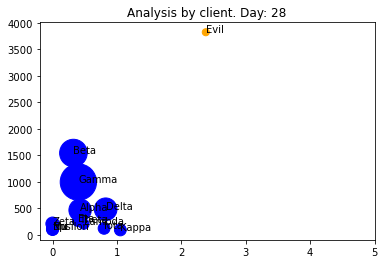

In [55]:
# you do not need to change the content of this cell
scatter_plot(df_joins_by_devices, day=28, by="client")

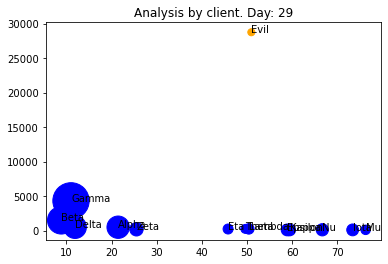

In [56]:
# you do not need to change the content of this cell
scatter_plot(df_joins_by_devices, day=29, by="client")

Note that the scale of the attacks completely changes on the day of the attack.

We will now look at the same data plotted by device.

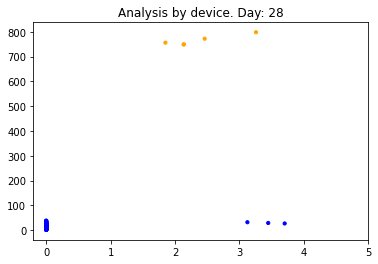

In [57]:
# you do not need to change the content of this cell
scatter_plot(df_joins_by_devices, day=28, by="device")

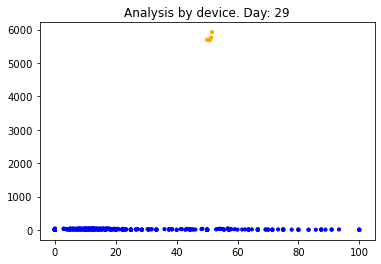

In [58]:
# you do not need to change the content of this cell
scatter_plot(df_joins_by_devices, day=29, by="device")

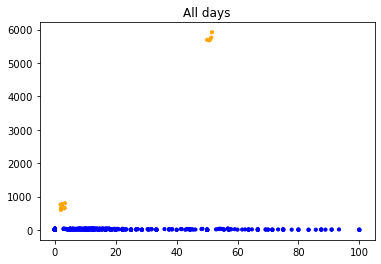

In [59]:
# you do not need to change the content of this cell
scatter_plot(df_joins_by_devices, by="device")

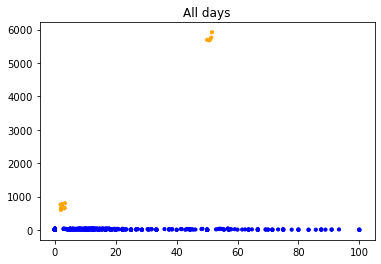

In [60]:
# you do not need to change the content of this cell
scatter_plot(df_joins_by_devices, by="device")

The last plot contains the amount of join requests by device on all days. Evil's devices appear in orange. The devices of the other clients appear in blue.

Evil's device clearly appear to be problematic. Now, we must prove it algorithmically. For this, we will switch to `numpy`.

### Python arrays (numpy)

NumPy is the fundamental package for scientific computing with Python. It contains among other things:
* a powerful N-dimensional array object
* sophisticated (broadcasting) functions
* tools for integrating C/C++ and Fortran code
* useful linear algebra, Fourier transform, and random number capabilities

(from https://www.numpy.org/).

We will use numpy to handle arrays and vectorize our functions. Here are a few examples of how to use numpy arrays.

To create a 3x2 matrix:

In [61]:
# you do not need to change the content of this cell
np.zeros(shape=(3, 2))

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

In [89]:
# you do not need to change the content of this cell
M = np.array([
    [1.1, 1.2],
    [2.1, 2.2],
    [3.1, 3.2]
])
M

3

Matrices elements can be accessed by their index.

In [63]:
# you do not need to change the content of this cell
M[1][1]  # Pyhton starts indexing at 0

2.2

In [64]:
# you do not need to change the content of this cell
M[2][0]

3.1

To select entires rows or columns, use a semicolon.

In [65]:
# you do not need to change the content of this cell
M[:,0]  # every row, column 0

array([1.1, 2.1, 3.1])

In [66]:
# you do not need to change the content of this cell
M[1,:]  # second row, all columns

array([2.1, 2.2])

To get the min or max value of a matrix, use the min and max functions. An axis can be specified.

In [67]:
# you do not need to change the content of this cell
M.min()

1.1

In [68]:
# you do not need to change the content of this cell
M.max(axis=0)  # max for each column

array([3.1, 3.2])

In [69]:
# you do not need to change the content of this cell
M.min(axis=1)  # min for each row

array([1.1, 2.1, 3.1])

A scalar can be added to or subtracted from a matrix. A matrix can be multiplied of divided by a scalar. 

In [70]:
# you do not need to change the content of this cell
1 + M

array([[2.1, 2.2],
       [3.1, 3.2],
       [4.1, 4.2]])

In [71]:
# you do not need to change the content of this cell
M - 1

array([[0.1, 0.2],
       [1.1, 1.2],
       [2.1, 2.2]])

In [72]:
# you do not need to change the content of this cell
M * 2

array([[2.2, 2.4],
       [4.2, 4.4],
       [6.2, 6.4]])

In [73]:
# you do not need to change the content of this cell
M / 2

array([[0.55, 0.6 ],
       [1.05, 1.1 ],
       [1.55, 1.6 ]])

To add or subtract matrices:

In [14]:
# you do not need to change the content of this cell
M1 = np.array([
    [1, 2],
    [3, 4]
])

In [15]:
# you do not need to change the content of this cel
M2 = np.array([
    [1, 0],
    [0, 1]
])

In [17]:
# you do not need to change the content of this cell
M1 + M2

array([[2, 2],
       [3, 5]])

In [77]:
# you do not need to change the content of this cell
M1 - M2

array([[0, 2],
       [3, 3]])

You can multiply matrices element wise.

In [78]:
# you do not need to change the content of this cell
M1 * M2

array([[1, 0],
       [0, 4]])

For classical matrix multiplication, use the @ symbol.

In [79]:
# you do not need to change the content of this cell
M12 = M1 @ M2
print(M12)
# Or you can use np.dot
M12 = np.dot(M1, M2)
print(M12)

[[1 2]
 [3 4]]
[[1 2]
 [3 4]]


To replace elements in matrices: use the `where` function (https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html).

In [81]:
# you do not need to change the content of this cell
M3 = np.where(M1==3, 72, M1)
M3

array([[ 1,  2],
       [72,  4]])

To sort an array, use `argsort`. `argsort` will return a sorted array containing the indices of the members.

In [85]:
M4 = np.array([3, 1, 2])
np.argsort(M4)

array([1, 2, 0])

We load our spark dataframe as a numpy array.

In [9]:
# you do not need to change the content of this cell
array = np.load('./data/array_joins_by_devices.npy') # load
print(array)

[(29, 'Evil', 'f8d07a11-7191-4523-bd85-464c2b9c2883', 5.918e+03, 3054., 51.60527205)
 (29, 'Evil', 'b4069cee-5796-415b-8344-52e9a92a24e5', 5.757e+03, 2957., 51.36355741)
 (29, 'Evil', '9ec9344a-a760-4605-b5ee-c234f30def49', 5.701e+03, 2904., 50.93843185)
 ...
 (27, 'Delta', '09b1b93d-f915-4dba-b054-6c7fcc57d6d9', 2.000e+00,    0.,  0.        )
 (27, 'Iota', '346bc7fb-8210-4765-8d5c-cf2bb5c17348', 1.000e+00,    0.,  0.        )
 (27, 'Gamma', '0e5d7e0e-e431-48a3-b1e6-dfbdcd325c5a', 1.000e+00,    0.,  0.        )]


Before runing any machine learning algorithms, we should normalize our data. We will implement the Min-Max Feature scaling function, which brings all values X into the range \[a,b\] (usually \[0,1\]).

The formula is:

![min_max_scaling](./images/min_max_scaling.svg)

In [10]:
# you must change the content of this cell

def min_max_scaling(X:np.ndarray, a:float, b:float) -> np.ndarray:
    """
    This function normalizes numerical columns. Feature scaling brings all values into the range [a,b].
    
    Parameters
    ----------
    X : np.array
        A numpy array.
    a : float
        The min value.
    b : float
        The max value
        
    Returns
    -------
    scaled_array : np.array
        The array after scaling.
    """
    scaled_array=a+(X-min(X))*(b-a)/(max(X)-min(X))
    
    
    return scaled_array

In [11]:
# you do not need to change the content of this cell
# note: in this cell, we use numpy structured arrays, which allow to name columns (scaled_array["nb_records"]).
# we will not use this feature anymore.
scaled_array = np.copy(array)
scaled_array["nb_records"] = min_max_scaling(scaled_array["nb_records"][:,np.newaxis], 0., 1.)[:,0]
scaled_array["nb_errors"] = min_max_scaling(scaled_array["nb_errors"][:,np.newaxis], 0., 1.)[:,0]

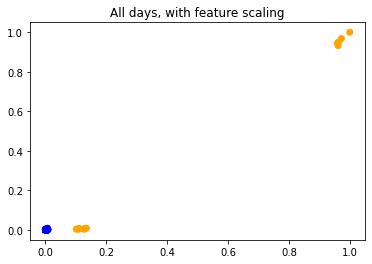

In [12]:
# you do not need to change the content of this cell
_scatter_plot(labels=[], x_axis=scaled_array["nb_records"], y_axis=scaled_array["nb_errors"], color=["orange" if di == "Evil" else "b" for di in scaled_array['Downlink-CRM-ClientID']], title="All days, with feature scaling")

# Local Outlier Factor


## Introduction

Today, we will implement the Local Outlier Factor (LOF) algorithm. 

The LOF algorithm is an outlier detection alorithm. Here is Hawkins’s definition of outliers: "An outlier is an observation which deviates so much from the other observations as to arouse suspicions that it was generated by a different mechanism."
 
You can find the original paper describing the LOF algorithm here: https://www.dbs.ifi.lmu.de/Publikationen/Papers/LOF.pdf. The Wikipedia page about the LOF is also a good resource: https://en.wikipedia.org/wiki/Local_outlier_factor.


## Main idea

The aim of the LOF algorithm is to find outliers in a set of data. The LOF algorithm solves this problem by calculating the distance between densities of points. The idea is to associate **each point** to a **coefficient** called **Local Outlier Factor** (note the ambiguity between LOF as coefficient and LOF as algorithm). This coefficient indicates "how much" the point can be considered as an outlier.

### A naive approach

The distance between points is frequently used as a clue of outliner-ness. For instance, in the following image, one may rationaly suspect the point A to be an outlier.

![simple_dist](./images/simpledist.png)

But let us have a look at the following picture:

![density_dist](./images/densitydist.png)

An naive distance-only algorithm would either:
* not identify A as an outlier, because the distance that separates it from the closest group of points is not larger than the distance between the points in the upper group, or
* identify A and all the points in the upper group as outliers.

It is, however, quite usual that in a given pattern, some values are more "sparse" than others and these points are not especially outliers.


### The Idea behind the LOF

The LOF algorithm goes one step further and compares "how isolated" is a point in comparison to  how its neighbours points are isolated. If a point is "more isolated" than its neighbours "are isolated" it is considered as an outlier.

## Mathematical formulation: 

Let us consider a data set $D = \{x_1, \dots, x_n \}$ which elements are points in $\mathbb{R}^N$. And let us note the (Euclidean) distances between points $A$ and $B$ as $d(A, B)$.

We define the **$k$-distance** of $A$ as the distance from $A$ to its $k^{th}$-nearest point: $D_{k}(A)$.

We define the **$k$-neighbours** of $A$, the set $N_{k}(A)$ of all points that are not further from $A$ than $D_k(a)$:

$$ N_{k}(A) = \{ B \in D | d(A, B) \leq d_{k}(A) \} $$

Note that $N_{k}(A)$ may contain more than $k$ points.

The **reachability distance** between $A$ and $B$ is defined as 

$$ RD(A, B) = max(D_{k}(B), d(A, B)) $$

Note that the $RD$ is the usual distance between $A$ and $B$ if $A$ is not in $N_{k}(B)$ and is equal to $D_{k}(B)$ otherwise.

<img src="./images/LOF2.jpg" alt="Naive LOF" width="400"/>

In fact, the $LOF$ algorithm would also make sense with a usual distance. However, the use of $RD$ has proven to give more stable results (a few very close points will not lead to extreme densities). 

**BE CAREFULL:** In a strict mathematical definition, this is not a distance!!!

$RD$ is not symmetric, which is one of the axions of a mathematical distance. 

It is possible than for example $A$ is in $N_{k}(B)$, but $B$ is not in $N_{k}(A)$.

In this case: 

$$RD(A,B) = D_k(B)\geq d(A,B)$$
$$RD(B,A) = d(A,B)$$

Then, we define the **local reachability density** of $A$ as 

$$ LRD_{k}(A) = \frac{|N_k(A)|}{\sum_{B \in N_{k}(A)}RD_{k}(A, B)} $$

Which is basically the inverse of the mean of the $RD$'s of $A$ from its $k$-neighbours.
If for example $A$ is more isolated than its neighbours, they will have in general a larger $LRD$ than $A$. The $LRD$ can be seen as an indicator of how closely sourounded a points is by its closest $k$-neighbours.

Finally, we define the **Local Outlier Factor** as

$$ LOF_{k}(A) = \frac{\sum_{B \in N_{k}(A)}LRD_{k}(B)}{|N_k(A)|LRD_{k}(A)} $$

which correponds to the mean of the $LRD$ of $N_{k}(A)$ compared to the $LRD$ of $A$. So, it compares how mush a point is closely related to its neighbours than its neighors are closely related to their neighbours.

In other words, it compares the $LRD$ of $A$ to the $LRD$ of its neighbours.

So, we have defined the $LOF$ coefficient for each point. 

If $LOF(A)$ is **around $1$ or smaller**, the point is **not an outlier**.

If $LOF(A)$ is much **larger than $1$** (we can choose a threshold), then it can be considered as an **outlier**.

### Visualization

The following image can give you a visual intuition of the LOF:

<img src="./images/LOF3.png" alt="LOF" width="400"/>
(Image from: https://en.wikipedia.org/wiki/Local_outlier_factor)

In this image, $A$ seems isolated form the cluster of points on the right, so the $LRD$ of $A$ is smaller than the $LRD$ of the points on the right. This leads to a larger $LOF$.

Indeed, the neighbours of the points in the cluster are other points from the cluster, and their $RD$ are generally smaller. $A$ consider them as its neighbours, but they do not consider $A$ as they neighbour, since they have colser ones.


In the following plot, we show the points with a size that increases as the $LOF$ (with $k=5$) of the point increases.

<img src="./images/LOF4.jpg" alt="LOF" width="550"/>

We see that the average size of the points of the cluster in the top-left corner is not really different from the average size of the points in the bottom-right corner, even if the two groups have different **densities**.
On the other hand, the tree isolated points are here clearly detected as ouliers.

The LOF algorithm requires (numerical) points. In our case, `nb_records` and `nb_errors`. 

In [74]:
# you do not need to change the content of this cell
points = np.empty(shape=(scaled_array.shape[0], 2), dtype=np.float)
points[:,0] = scaled_array["nb_records"]
points[:,1] = scaled_array["nb_errors"]
distMat=np.linalg.norm(points - points[:,None], axis = -1)
A=distMat.argsort()[:,:100]
kFirstDist = np.empty(shape=(len(points),100), dtype=np.float)
for i in range(len(points)):
    for j in range(100):
        kFirstDist[i,j]=distMat[i,A[i,j]]


[[       inf 1.         0.5        0.33333333]
 [0.25       0.2        0.16666667 0.14285714]
 [0.125      0.11111111 0.1        0.09090909]]


<ipython-input-74-a8996413b509>:12: RuntimeWarning: divide by zero encountered in true_divide
  print(1/x)


LOF receives two parameters:
* `points`
* `k` the numbers of neighbours we consider for all the points.

You can code tje LOF by using loops or vectorized functions of numpy. Note that generally the vectorized functions are mush faster than loops, but if you don't feel comfortable with numpy, feel free to use loops.

**Remark:**

The skeleton of our LOF algorithm seems to suggest that the set of neighbour, $N_k(A)$ of a point $A$ always contains exactly $k$ elements. Which is, as mentioned previously, not always the case.  
For simplicity, we accept that you forget about this problem for now. However, if you have some time left, feel free to implement a version of the LOF algorithm that can handle the case when $|N_k(A)| \neq k$.

In [89]:
# you must change the content of this cell

def LOF(points:np.ndarray, k:int) -> np.ndarray:
    n = len(points)
    # (1) -----------------------------------------------------------------------------
    # Find distance matrix:                                               (n, n)-matrix
    distMat = np.linalg.norm(points - points[:,None], axis = -1)  # L2 norm
    
    # (2) -----------------------------------------------------------------------------
    # Find k nearest points id matrix sorted by order:                    (n, k)-matrix
    kFirstNeib = distMat.argsort()[:,:k]
    # Find k nearest point-distances
    kFirstDist = np.empty(shape=(n,k), dtype=np.float)
    for i in range(n):
        for j in range(k):
            kFirstDist[i,j]=distMat[i,kFirstNeib[i,j]]
    
    # (3) -----------------------------------------------------------------------------
    # Find k-distances                                                          n-array
    kD = kFirstDist[:,-1]
    # Find reachability distances                                        (n, k)-matrix    
    RD = np.empty(shape=(n,k), dtype=np.float)
    for i in range(n):
        for j in range(k):
            RD[i,j]=max(kD[j],kFirstDist[i,j])
    # (4) -----------------------------------------------------------------------------
    # Find local reachability distances                                         n-array        
    RDmean = np.mean(RD, 1)
    LRD = 1/RDmean
    
    # (5) -----------------------------------------------------------------------------
    # Find local outlier factor                                                 n-array
    LRDmean=np.mean(LRD)
    lof = LRDmean/LRD
    
    return lof

In [90]:
lof_scores = LOF(points, k=20)

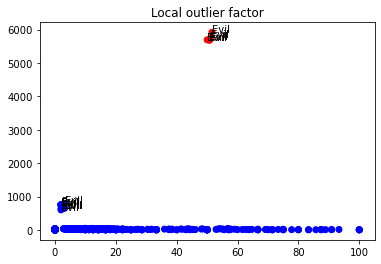

In [91]:
# you do not need to change the content of this cell
_scatter_plot(
    labels=["Evil" if di == "Evil" else None for di in scaled_array['Downlink-CRM-ClientID']],
    x_axis=array["pct_errors"],
    y_axis=array["nb_records"],
    color=["r" if s > 1.5 else "b" for s in lof_scores],
    title="Local outlier factor"
)

 End